In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
from skimage.morphology import erosion
from skimage.morphology import disk
from skimage.filters import prewitt
import math
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from skimage import color, io, measure, segmentation, img_as_ubyte
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.color import label2rgb
from scipy.spatial import distance
from skimage.transform import rotate
from skimage.transform import EuclideanTransform
from skimage.transform import warp
from skimage.transform import matrix_transform

c:\Users\minni\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


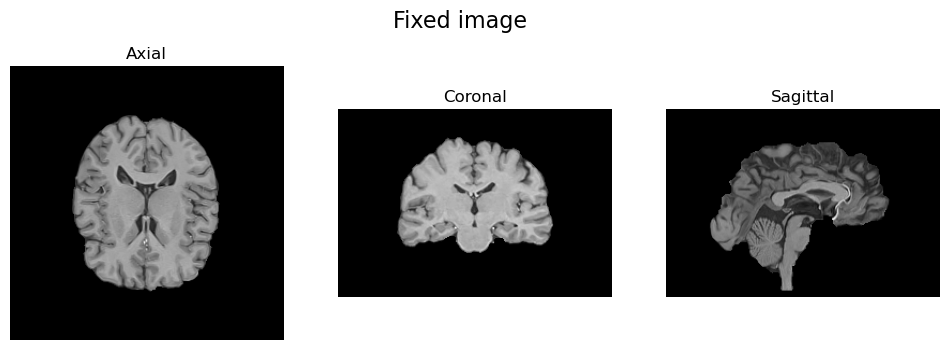

TypeError: Invalid shape (11534336,) for image data

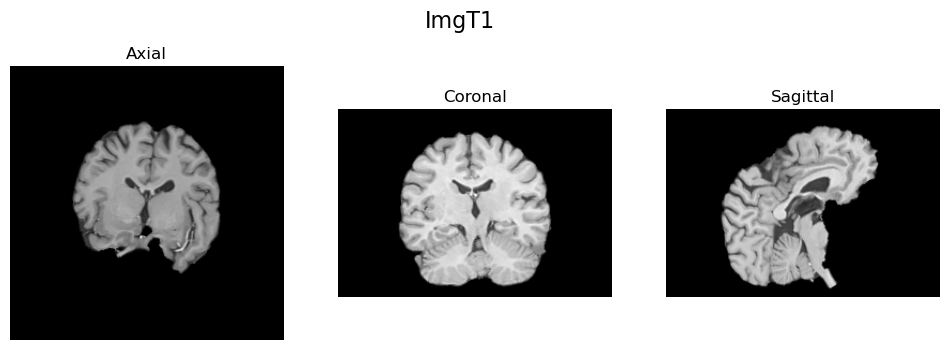

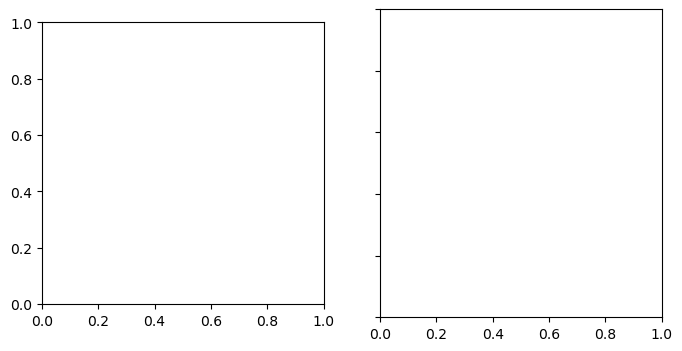

In [38]:
import SimpleITK as sitk
import numpy as np
from skimage import filters, morphology
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte

# Load the template image
folder_in = 'data/brain/'
template_image = sitk.ReadImage('C:/Users/minni/GitHub/2024-spring-dtu/02502_ImageAnalysis/DTUImageAnalysis/myExam/data/brain/T1_brain_template.nii.gz')

# from ex9 
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def rotation_matrix(pitch, roll, yaw, deg = False):
    """
    Return the rotation matrix associated with the Euler angles roll, pitch, yaw.
    
    Parameters
    ----------
    pitch : float
        The rotation angle around the x-axis.
    roll : float
        The rotation angle around the y-axis.
    yaw : float
        The rotation angle around the z-axis.
    deg : bool, optional
        If True, the angles are given in degrees. If False, the angles are given
        in radians. Default: False.
    """
    if deg:
        roll = np.deg2rad(roll)
        pitch = np.deg2rad(pitch)
        yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0,             0,             0],
                    [0, np.cos(pitch),  -np.sin(pitch),  0],
                    [0, np.sin(pitch), np.cos(pitch),  0],
                    [0, 0,             0,             1]])

    R_y = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                    [0, 1, 0, 0],
                    [-np.sin(roll), 0, np.cos(roll), 0],
                    [0, 0, 0, 1]])

    R_z = np.array([[np.cos(yaw),  -np.sin(yaw), 0, 0],
                    [np.sin(yaw), np.cos(yaw),  0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    R = np.dot(np.dot(R_x, R_y), R_z)

    return R

imshow_orthogonal_view(template_image, title='Fixed image')
plt.show()

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(template_image.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = template_image.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(np.deg2rad(-30), 0, np.deg2rad(10))[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
output = sitk.Resample(template_image, transform)

# Visualize the rotated image
imshow_orthogonal_view(output, title=f'ImgT1')

# Save the rotated image
# sitk.WriteImage(output, f'{dir_in}ImgT1_{angle}.nii')

# Convert SimpleITK image to NumPy array
image = sitk.GetArrayFromImage(template_image)

# Apply Otsu thresholding
threshold = filters.threshold_otsu(image)
binary_image = image > threshold  # Binarize the image based on threshold

# Generate ball-shaped structuring element
radius = 3  # Adjust radius as needed
footprint = morphology.ball(radius)

# Apply morphological closing and erosion
closed_image = morphology.closing(binary_image, footprint)
eroded_image = morphology.erosion(closed_image, footprint)

def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

plot_comparison(template_image, eroded_image, 'hi')

In [50]:
import cv2
import numpy as np

# Simulate image loading (replace with actual image loading if possible)
image = cv2.imread('data/pots/pots.jpg')  # Replace 'pots.jpg' with your image path (if available)

# Extract red channel (assuming BGR color format)
red_channel = image[:, :, 2]

# Apply median filter with odd-sized kernel (e.g., 9x9)
median_filtered = cv2.medianBlur(red_channel, ksize=9)  # Change ksize to an odd number

# Threshold the image
thresholded_image = np.where(median_filtered > 200, 255, 0)  # Set foreground to 255

# Option 1: Percentage Estimation (if image unavailable)
image_width, image_height = image.shape[:2]  # Assuming image is available
estimated_foreground_pixels = 0.05 * image_width * image_height


print(estimated_foreground_pixels)


7380.0


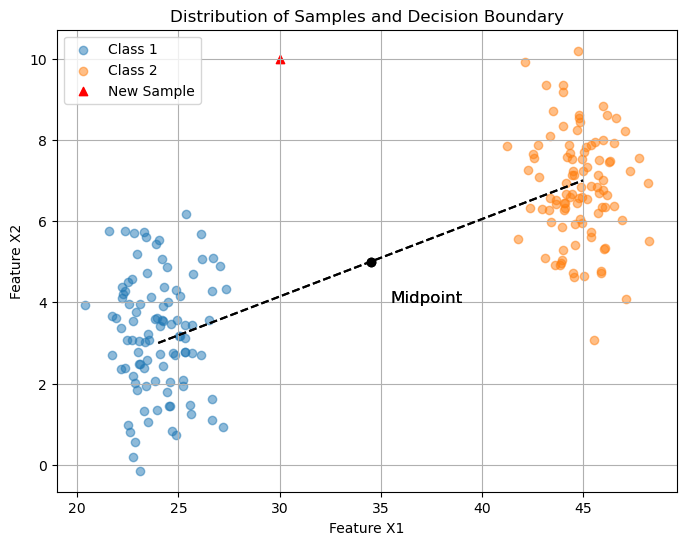

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
np.random.seed(0)
mean1, cov1 = [24, 3], [[2, 0], [0, 2]]
mean2, cov2 = [45, 7], [[2, 0], [0, 2]]
samples_class1 = np.random.multivariate_normal(mean1, cov1, 100)
samples_class2 = np.random.multivariate_normal(mean2, cov2, 100)

plt.figure(figsize=(8, 6))
plt.scatter(samples_class1[:, 0], samples_class1[:, 1], label='Class 1', alpha=0.5)
plt.scatter(samples_class2[:, 0], samples_class2[:, 1], label='Class 2', alpha=0.5)

# Plot the decision boundary
midpoint = [(24+45)/2, (3+7)/2]
plt.plot([24, 45], [3, 7], 'k--')  # Line connecting means
plt.scatter(*midpoint, marker='o', color='black')
plt.text(midpoint[0]+1, midpoint[1]-1, 'Midpoint', fontsize=12)

# plt.xlabel('Feature X1')
# plt.ylabel('Feature X2')
# plt.legend()
# plt.title('Distribution of Samples and Decision Boundary')
# plt.grid(True)
# plt.show()

# ... (rest of your code for generating data and plotting samples)

# New sample to plot
new_sample = [30, 10]

# Plot the decision boundary (unchanged)
plt.plot([24, 45], [3, 7], 'k--')  # Line connecting means
plt.scatter(*midpoint, marker='o', color='black')
plt.text(midpoint[0]+1, midpoint[1]-1, 'Midpoint', fontsize=12)

# Plot the new sample in a different color or marker
plt.scatter(new_sample[0], new_sample[1], marker='^', color='red', label='New Sample')  # Adjust marker and color as desired

plt.xlabel('Feature X1')
plt.ylabel('Feature X2')
plt.legend()
plt.title('Distribution of Samples and Decision Boundary')
plt.grid(True)
plt.show()


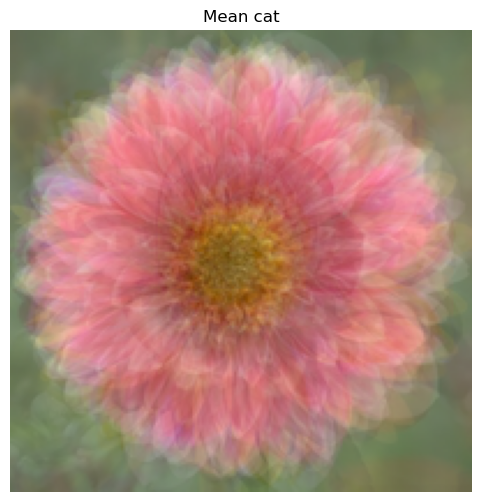

In [66]:
# from ex8

from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib

import cv2

def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

# Define the data directory
raw_dir = "data/flowers/"
preprocess_dir = "data/flowers/"
os.makedirs(preprocess_dir, exist_ok=True)

files = glob.glob(f"{preprocess_dir}/*.jpg")

height, width, channels = io.imread(files[0]).shape
data_matrix = np.zeros((len(files), height * width * channels))
for i, f in enumerate(files):
    data_matrix[i, :] = io.imread(f).flatten()

# average flower

average_cat = np.mean(data_matrix, axis=0)

average_cat_img = create_u_byte_image_from_vector(average_cat, height, width, channels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(average_cat_img)
ax.set_title("Mean cat")
ax.set_axis_off()
plt.show()


# variation

w0, w1 = 60000, 60000
synth_cat = average_cat + w0 * cats_pca.components_[0, :] + w1 * cats_pca.components_[1, :]
synth_cat_img = create_u_byte_image_from_vector(synth_cat, height, width, channels)
plt.imshow(synth_cat_img)
plt.show()

def visualize_mode_of_variation(m):
    synth_cat_plus = average_cat + 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
    synth_cat_minus = average_cat - 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(create_u_byte_image_from_vector(synth_cat_minus, height, width, channels))
    ax[0].set_title("Cat - 3$\sigma$")
    ax[1].imshow(create_u_byte_image_from_vector(average_cat, height, width, channels))
    ax[1].set_title("Average cat")
    ax[2].imshow(create_u_byte_image_from_vector(synth_cat_plus, height, width, channels))
    ax[2].set_title("Cat + 3$\sigma$")
    fig.suptitle("Mode of variation PC{}".format(m + 1))

In [91]:
import numpy as np

def gradient_descent(x1, x2, step_size, num_iterations):
  """
  Performs gradient descent on the cost function C(x1, x2) = x1^2 + x1*x2 + 3*x2 + x1.

  Args:
    x1: The initial value of x1.
    x2: The initial value of x2.
    step_size: The step size to use in the gradient descent algorithm.
    num_iterations: The number of iterations to perform.

  Returns:
    The final values of x1 and x2.
  """

  for i in range(num_iterations):
    # Compute the gradient of the cost function.
    gradient = np.array([x1**2 + x2*x1, x2**2 * 3+ x1**3])

    # Update the values of x1 and x2.
    x1 -= step_size * gradient[0]
    x2 -= step_size * gradient[1]

    # Calculate the cost function value.
    cost = x1**2 + x1*x2 + 3*x2 + x1

    # Check if the cost is below the threshold.
    if cost < 0.20:
      print(f"C(x1, x2) is below 0.20 at iteration {i + 1}.")
      print(f"x1: {x1:.4f}")
      print(f"x2: {x2:.4f}")
      return x1, x2

  return x1, x2


# Set the initial values of x1 and x2.
x1 = 4
x2 = 3

# Set the step size and the number of iterations.
step_size = 0.07
num_iterations = 100

# Perform gradient descent.
x1, x2 = gradient_descent(x1, x2, step_size, num_iterations)

# If the cost never falls below the threshold, print a message.
if x1 is None or x2 is None:
  print("C(x1, x2) did not fall below 0.20 within the specified number of iterations.")

C(x1, x2) is below 0.20 at iteration 1.
x1: 2.0400
x2: -3.3700


In [95]:
import numpy as np

def cost_function(x1, x2):
    return x1**2 + x2*x1, x2**2 * 3+ x1**3

def gradient_cost_function(x1, x2):
    grad_x1 = 2*x1 - x2
    grad_x2 = -x1 + 6*x2
    return np.array([grad_x1, grad_x2])
def gradient_descent(cost_function, gradient_cost_function, x_init, step_size, threshold=0.20):
    x_current = x_init.copy()
    cost_history = []
    
    while True:
        # Calculate current cost
        cost = cost_function(*x_current)
        
        # Append cost to history
        cost_history.append(cost)
        
        # Check if cost is below threshold
        if float(cost) < threshold:
            break
        
        # Update parameters using gradient descent
        grad = gradient_cost_function(*x_current)
        x_current -= step_size * grad
    
    return x_current, cost_history

# Initial values
x_init = np.array([4, 3])

# Run gradient descent
optimal_translation, costs = gradient_descent(cost_function, gradient_cost_function, x_init, 0.07)

print("Optimal Translation:", optimal_translation)


TypeError: float() argument must be a string or a real number, not 'tuple'

In [96]:
def gradient_descent(x1, x2, learning_rate, tolerance):
  """
  Performs gradient descent optimization on the given cost function.

  Args:
      x1: Initial value for parameter 1.
      x2: Initial value for parameter 2.
      learning_rate: Step length for parameter updates.
      tolerance: Threshold for convergence of the cost function.

  Returns:
      iterations: Number of iterations needed to reach the tolerance.
      new_x1: Updated value of parameter 1 after convergence.
      new_x2: Updated value of parameter 2 after convergence.
  """
  # Initial values
  current_x1 = x1
  current_x2 = x2
  iteration = 0

  # Loop until convergence or maximum iterations
  while C(current_x1, current_x2) > tolerance and iteration < 1000:  # Maximum 1000 iterations
    # Calculate partial derivatives
    partial_x1 = 2 * current_x1 - current_x2 + 3 * current_x1**2
    partial_x2 = -current_x1 + 6 * current_x2

    # Update parameters
    new_x1 = current_x1 - learning_rate * partial_x1
    new_x2 = current_x2 - learning_rate * partial_x2

    # Update for next iteration
    current_x1 = new_x1
    current_x2 = new_x2
    iteration += 1

  return iteration, new_x1, new_x2

def C(x1, x2):
  """
  Defines the cost function for image registration.
  """
  return x1**2 - x1 * x2 + 3 * x2**2 + x1**3

# Starting point and parameters
x1, x2 = 4, 3
tolerance = 0.20
learning_rate = 0.07

# 1. Number of iterations for C(x1, x2) < 0.20
iterations, new_x1, new_x2 = gradient_descent(x1, x2, learning_rate, tolerance)
print("Number of iterations for C(x1, x2) < 0.20:", iterations)

# 2. x1 after 5 iterations (regardless of convergence)
_, x1_after_5, _ = gradient_descent(x1, x2, learning_rate, 0.0)  # Set tolerance to 0 for 5 iterations
print("x1 after 5 iterations:", x1_after_5)


Number of iterations for C(x1, x2) < 0.20: 6
x1 after 5 iterations: 2.4386776824608302e-58


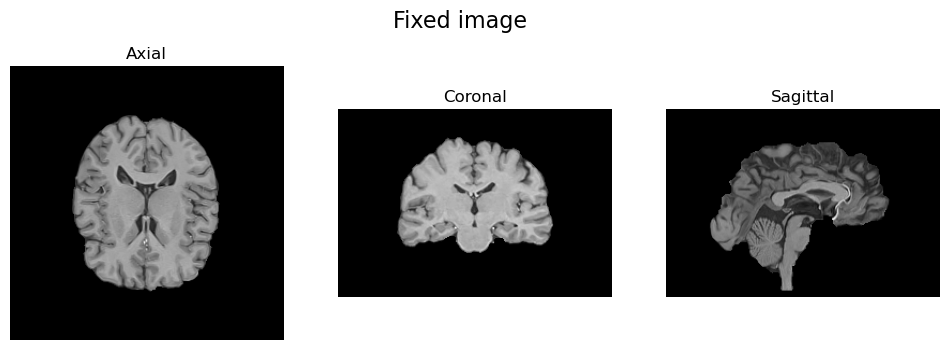

TypeError: Invalid shape (11534336,) for image data

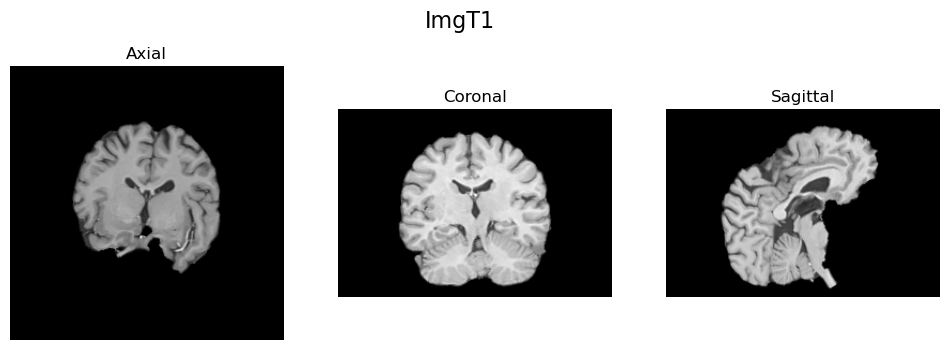

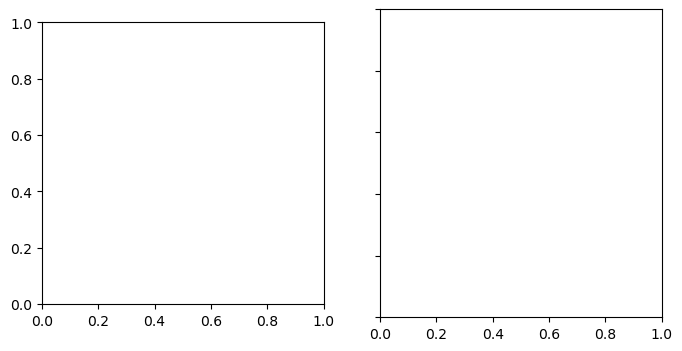

In [ ]:
import SimpleITK as sitk
import numpy as np
from skimage import filters, morphology
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte

# Load the template image
folder_in = 'data/brain/'
template_image = sitk.ReadImage('C:/Users/minni/GitHub/2024-spring-dtu/02502_ImageAnalysis/DTUImageAnalysis/myExam/data/brain/T1_brain_template.nii.gz')

# from ex9 
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def rotation_matrix(pitch, roll, yaw, deg = False):
    """
    Return the rotation matrix associated with the Euler angles roll, pitch, yaw.
    
    Parameters
    ----------
    pitch : float
        The rotation angle around the x-axis.
    roll : float
        The rotation angle around the y-axis.
    yaw : float
        The rotation angle around the z-axis.
    deg : bool, optional
        If True, the angles are given in degrees. If False, the angles are given
        in radians. Default: False.
    """
    if deg:
        roll = np.deg2rad(roll)
        pitch = np.deg2rad(pitch)
        yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0,             0,             0],
                    [0, np.cos(pitch),  -np.sin(pitch),  0],
                    [0, np.sin(pitch), np.cos(pitch),  0],
                    [0, 0,             0,             1]])

    R_y = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                    [0, 1, 0, 0],
                    [-np.sin(roll), 0, np.cos(roll), 0],
                    [0, 0, 0, 1]])

    R_z = np.array([[np.cos(yaw),  -np.sin(yaw), 0, 0],
                    [np.sin(yaw), np.cos(yaw),  0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    R = np.dot(np.dot(R_x, R_y), R_z)

    return R

imshow_orthogonal_view(template_image, title='Fixed image')
plt.show()

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(template_image.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = template_image.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(np.deg2rad(-30), 0, np.deg2rad(10))[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
output = sitk.Resample(template_image, transform)

# Visualize the rotated image
imshow_orthogonal_view(output, title=f'ImgT1')

# Save the rotated image
# sitk.WriteImage(output, f'{dir_in}ImgT1_{angle}.nii')

# Convert SimpleITK image to NumPy array
image = sitk.GetArrayFromImage(template_image)

# Apply Otsu thresholding
threshold = filters.threshold_otsu(image)
binary_image = image > threshold  # Binarize the image based on threshold

# Generate ball-shaped structuring element
radius = 3  # Adjust radius as needed
footprint = morphology.ball(radius)

# Apply morphological closing and erosion
closed_image = morphology.closing(binary_image, footprint)
eroded_image = morphology.erosion(closed_image, footprint)

def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

plot_comparison(template_image, eroded_image, 'hi')

In [101]:
def cost(x, y):
    return x**2 - x * y + 3* y**2 + x**3

x1 = 4
x2 = 3
cur_cost = 100
while cur_cost > 0.2:
    cur_cost = cost(x1, x2)
    x1 -= 0.07
    print(x1)
    x2 -= 0.07
    print(cur_cost)
    


3.93
95
3.8600000000000003
90.38315700000001
3.7900000000000005
85.91125600000002
3.7200000000000006
81.58223900000003
3.650000000000001
77.39404800000004
3.580000000000001
73.34462500000005
3.510000000000001
69.43191200000005
3.4400000000000013
65.65385100000006
3.3700000000000014
62.00838400000006
3.3000000000000016
58.49345300000007
3.2300000000000018
55.10700000000008
3.160000000000002
51.846967000000085
3.090000000000002
48.71129600000008
3.0200000000000022
45.69792900000009
2.9500000000000024
42.804808000000094
2.8800000000000026
40.02987500000009
2.8100000000000027
37.37107200000009
2.740000000000003
34.8263410000001
2.670000000000003
32.39362400000009
2.600000000000003
30.070863000000088
2.5300000000000034
27.856000000000087
2.4600000000000035
25.746977000000086
2.3900000000000037
23.74173600000009
2.320000000000004
21.838219000000088
2.250000000000004
20.034368000000086
2.180000000000004
18.32812500000008
2.1100000000000043
16.71743200000008
2.0400000000000045
15.2002310000000

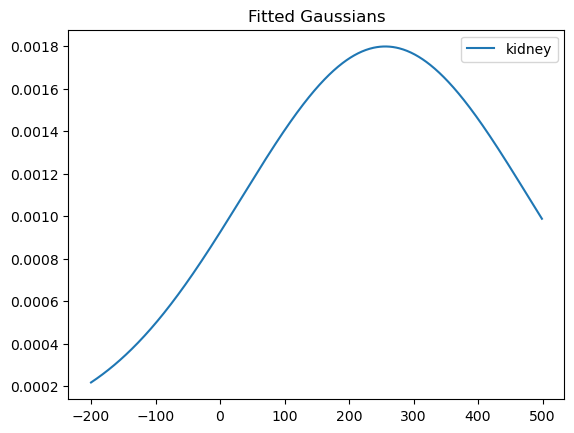

NameError: name 'mu_aorta' is not defined

In [107]:
def abdominal_analysis():
    in_dir = "data/vertebraCT/"
    ct = dicom.read_file(in_dir + '1-353.dcm')
    ground_truth_img = io.imread(in_dir + 'vertebra_gt.png')

    img = ct.pixel_array

    # liver_roi = io.imread(in_dir + 'LiverROI.png')
    # liver_mask = liver_roi > 0
    # liver_values = img[liver_mask]
    # liver_mean = np.average(liver_values)
    # liver_std = np.std(liver_values)
    # (mu_liver, std_liver) = norm.fit(liver_values)

    kidney_roi = io.imread(in_dir + 'vertebra_gt.png')
    kidney_mask = kidney_roi > 0
    kidney_values = img[kidney_mask]
    (mu_kidney, std_kidney) = norm.fit(kidney_values)

    # aorta_roi = io.imread(in_dir + 'AortaROI.png')
    # aorta_mask = aorta_roi > 0
    # aorta_values = img[aorta_mask]
    # (mu_aorta, std_aorta) = norm.fit(aorta_values)

    # back_roi = io.imread(in_dir + 'BackROI.png')
    # back_mask = back_roi > 0
    # back_values = img[back_mask]
    # (mu_back, std_back) = norm.fit(back_values)

    # Hounsfield unit limits of the plot
    min_hu = -200
    max_hu = 500
    hu_range = np.arange(min_hu, max_hu, 1.0)
    # pdf_back = norm.pdf(hu_range, mu_back, std_back)
    # pdf_aorta = norm.pdf(hu_range, mu_aorta, std_aorta)
    # pdf_liver = norm.pdf(hu_range, mu_liver, std_liver)
    pdf_kidney = norm.pdf(hu_range, mu_kidney, std_kidney)
    # plt.plot(hu_range, pdf_back, 'r--', label="back")
    # plt.plot(hu_range, pdf_aorta, 'g--', label="aorta")
    # plt.plot(hu_range, pdf_liver, label="liver")
    plt.plot(hu_range, pdf_kidney, label="kidney")
    plt.title("Fitted Gaussians")
    plt.legend()
    plt.show()

    # t_liver_kidney = (mu_liver + mu_kidney) / 2
    t_kidney_aorta = (mu_kidney + mu_aorta) / 2
    print(f"Thresholds: {t_liver_kidney:.1f}, {t_kidney_aorta:.1f}")

    t_background = -200
    kidney_img = (img > t_liver_kidney) & (img < t_kidney_aorta)
    io.imshow(kidney_img)
    io.show()

    gt_bin = ground_truth_img > 0
    dice_score = 1 - distance.dice(kidney_img.ravel(), gt_bin.ravel())
    print(f"DICE score {dice_score:.3f}")

abdominal_analysis()

In [111]:
import pydicom  # Assuming you have pydicom installed
import cv2  # Assuming you have OpenCV installed

# Input directory
in_dir = "data/vertebraCT/"

# Read DICOM data (assuming single slice)
dicom_data = dicom.read_file(in_dir + '1-353.dcm')

# Extract pixel data (assuming grayscale image)
seg_binary = dicom_data.pixel_array  # This might need adjustments based on data type

# Load expert's mask (assuming grayscale)
gt_binary = cv2.imread(in_dir + 'vertebra_gt.png', cv2.IMREAD_GRAYSCALE)

# Calculate intersection (common foreground pixels)
intersection = np.sum(seg_binary * gt_binary)

# Calculate total foreground pixels in each image
total_seg = np.sum(seg_binary)
total_gt = np.sum(gt_binary)

# Dice Score
dice_score = (2 * intersection) / (total_seg + total_gt)

print("Dice Score:", dice_score)


Dice Score: 0.08933865158888538


In [120]:
import pydicom
from skimage import measure
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

# Load the DICOM file
# Input directory
in_dir = "data/vertebraCT/"

# Read DICOM data (assuming single slice)
ds = dicom.read_file(in_dir + '1-353.dcm')

# Convert the DICOM image to a SimpleITK image
image = sitk.GetImageFromArray(ds.pixel_array)
image.SetSpacing((ds.PixelSpacing[0], ds.PixelSpacing[1]))

# Threshold the image to isolate the vertebra
threshold_value = 
binary_image = sitk.BinaryThreshold(image, lowerThreshold=threshold_value, upperThreshold=np.inf, insideValue=1, outsideValue=0)

# Perform morphological closing to reduce noise
closing_radius = 3
closed_image = sitk.MorphologicalClosing(binary_image, sitk.GetDiskShape(radius=closing_radius))

# Label connected components (blobs)
labels = sitk.LabelConnectedComponents(closed_image, connectivity=1)

# Filter blobs by area
min_area = 500
max_area = labels.GetSize()[0]
filtered_labels = sitk.LabelComponentStatistics(labels, sitk.LabelRegion())
filtered_blobs = [label for label, stats in filtered_labels.items() if min_area <= stats['Size'] <= max_area]

# Create a mask for the final segmentation
final_segmentation = sitk.Image(labels.GetSize(), sitk.sitkUInt8)
for label in filtered_blobs:
    final_segmentation = sitk.Cast(final_segmentation, sitk.sitkUInt8)
    final_segmentation += sitk.Cast(labels == label, sitk.sitkUInt8)

# Save the final segmentation
sitk.WriteImage(final_segmentation, 'segmentation.mha')

# Load the ground truth mask
ground_truth_mask = sitk.ReadImage('vertebra_gt.png', sitk.sitkUInt8)

# Calculate the DICE score
dice_score = sitk.GetDiceCoefficient(final_segmentation, ground_truth_mask)
print(f"DICE Score: {dice_score}")

# Plot histograms of Hounsfield units in the masked part of the vertebra
masked_pixels = final_segmentation * ds.pixel_array
histogram, edges = np.histogram(masked_pixels, bins=100, range=(np.min(masked_pixels), np.max(masked_pixels)))
plt.bar(edges[:-1], histogram, width=np.diff(edges))
plt.xlabel('Hounsfield Units')
plt.ylabel('Frequency')
plt.title('Histogram of Hounsfield Units in the Vertebra')
plt.show()


RuntimeError: Exception thrown in SimpleITK BinaryThreshold: D:\a\1\sitk-build\ITK-prefix\include\ITK-5.3\itkBinaryThresholdImageFilter.hxx:221:
ITK ERROR: BinaryThresholdImageFilter(00000228C21BC620): Lower threshold cannot be greater than upper threshold.

Number of features: 14 and number of observations: 178


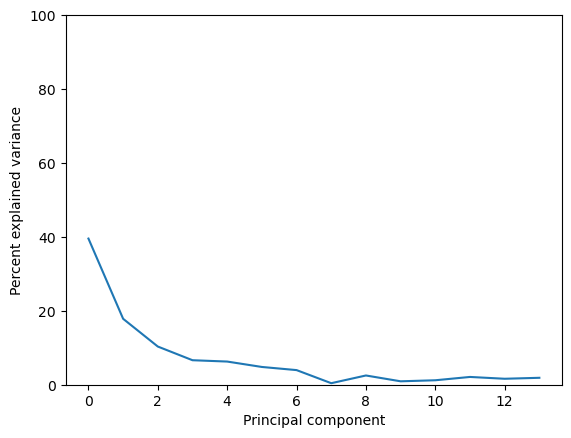

Answer: Variance explained by the first two PC: 57.38
Difference between maximum and minimum values on the first principal component: 4.98


c:\Users\minni\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\minni\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\minni\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

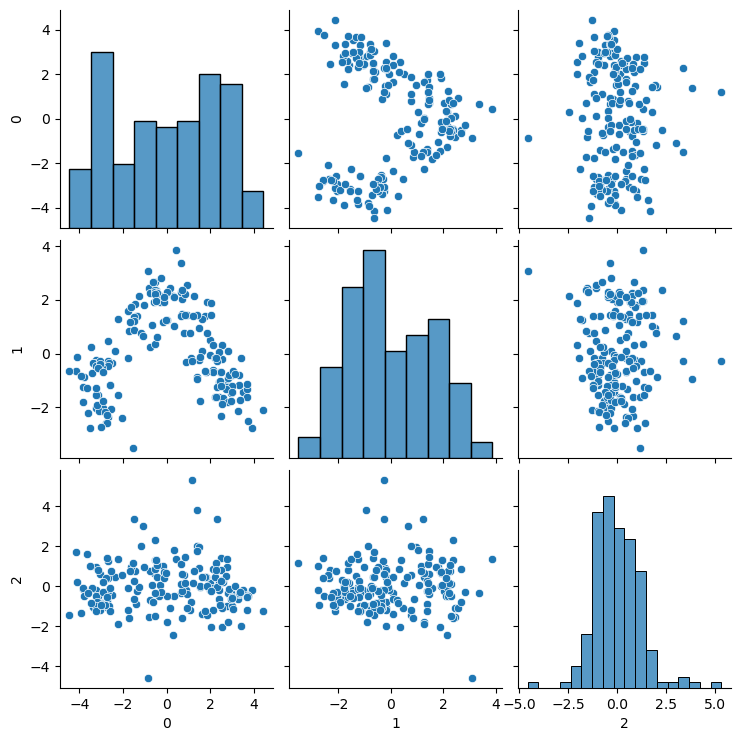

In [125]:
# E 2022
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def pca_on_car_data():
    in_dir = "data/winePCA/"
    txt_name = "wine-data.txt"

    car_data = np.loadtxt(in_dir + txt_name, comments="%")
    x = car_data
    n_feat = x.shape[1]
    n_obs = x.shape[0]
    print(f"Number of features: {n_feat} and number of observations: {n_obs}")

    mn = np.mean(x, axis=0)
    data = x - mn
    data = data / data.std(axis=0)
    c_x = np.cov(data.T)

    values, vectors = np.linalg.eig(c_x)
    v_norm = values / values.sum() * 100

    plt.plot(v_norm)
    plt.xlabel('Principal component')
    plt.ylabel('Percent explained variance')
    plt.ylim([0, 100])
    plt.show()

    answer = v_norm[0] + v_norm[1]
    print(f"Answer: Variance explained by the first two PC: {answer:.2f}")

    # Project data
    pc_proj = vectors.T.dot(data.T)

    # Extract the first principal component
    pc_first = pc_proj[:, 0]

    # Find the minimum and maximum values
    min_val = np.min(pc_first)
    max_val = np.max(pc_first)

    # Compute the difference
    diff = max_val - min_val
    print(f"Difference between maximum and minimum values on the first principal component: {diff:.2f}")

    # Plotting the projected data (optional)
    pc_proj_red = pc_proj[0:3, :]
    plt.figure()
    d = pd.DataFrame(pc_proj_red.T)
    sns.pairplot(d)
    plt.show()

pca_on_car_data()


Number of features: 14 and number of observations: 178
First answer at top of matrix 1.52


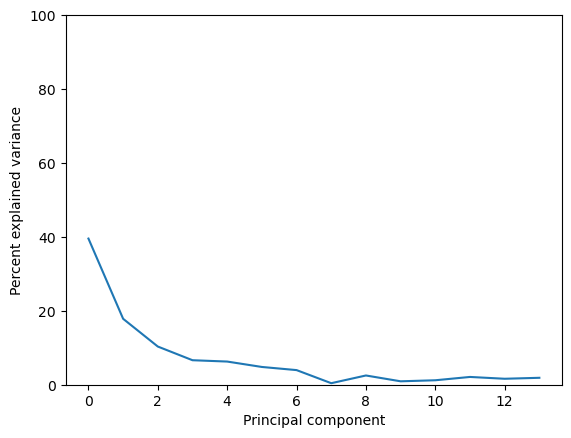

Answer: Variance explained by the first two PC: 57.38
Projected answer: 3.52


c:\Users\minni\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\minni\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\minni\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

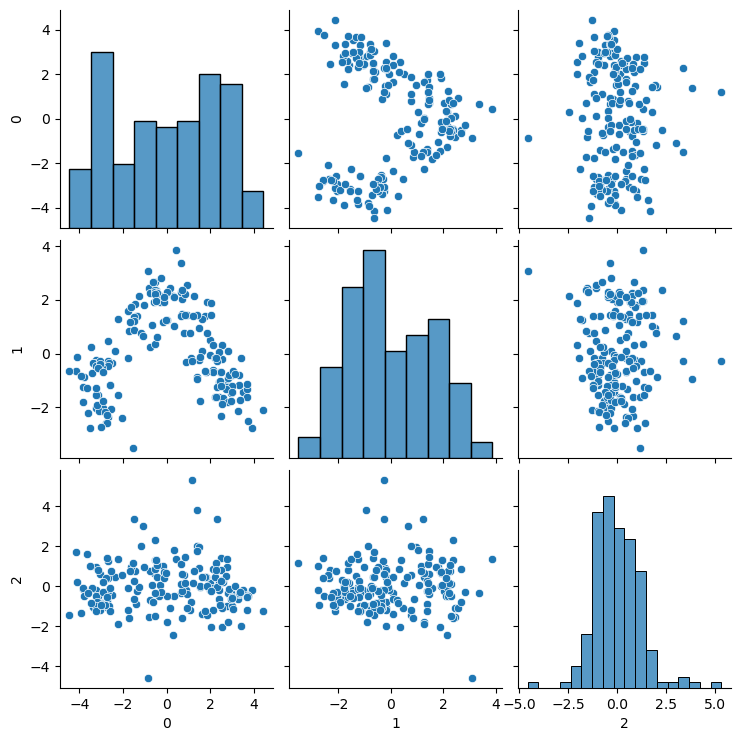

In [132]:
# E2022
def pca_on_car_data():
    in_dir = "data/winePCA/"
    txt_name = "wine-data.txt"

    car_data = np.loadtxt(in_dir + txt_name, comments="%")
    x = car_data
    n_feat = x.shape[1]
    n_obs = x.shape[0]
    print(f"Number of features: {n_feat} and number of observations: {n_obs}")

    # plt.figure()
    # Transform the data into a Pandas dataframe
    # d = pd.DataFrame(x)
    # sns.pairplot(d)
    # plt.show()

    mn = np.mean(x, axis=0)
    data = x - mn
    data = data / data.std(axis=0)
    c_x = np.cov(data.T)

    print(f"First answer at top of matrix {data[0][0]:.2f}")

    values, vectors = np.linalg.eig(c_x)

    v_norm = values / values.sum() * 100
    plt.plot(v_norm)
    plt.xlabel('Principal component')
    plt.ylabel('Percent explained variance')
    plt.ylim([0, 100])
    plt.show()

    answer = v_norm[0] + v_norm[1]
    print(f"Answer: Variance explained by the first two PC: {answer:.2f}")

    # Project data
    pc_proj = vectors.T.dot(data.T)
    print(f"Projected answer: {pc_proj[0][0]:.2f}")

    pc_proj_red = pc_proj[0:3, :]
    # pc_proj_red = pc_proj[5:8, :]

    # Answer 3
    plt.figure()
    # Transform the data into a Pandas dataframe
    d = pd.DataFrame(pc_proj_red.T)
    sns.pairplot(d)
    # plt.savefig('pairplot_5.png')
    plt.show()

pca_on_car_data()

Number of features: 13 and number of observations: 178


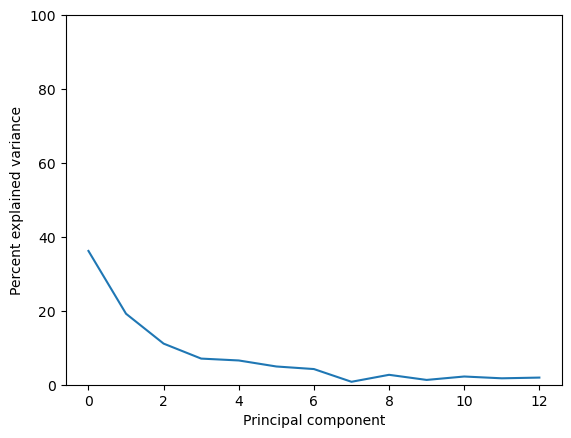

IndexError: boolean index did not match indexed array along dimension 0; dimension is 13 but corresponding boolean dimension is 178

In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def pca_on_wine_data():
    in_dir = "data/winePCA/"
    txt_name = "wine-data.txt"

    # Load the data
    car_data = np.loadtxt(in_dir + txt_name, comments="%")
    x = car_data[:, :-1]  # Measurements
    producer = car_data[:, -1]  # Producer information

    n_feat = x.shape[1]
    n_obs = x.shape[0]
    print(f"Number of features: {n_feat} and number of observations: {n_obs}")

    # Scale the measurements
    mn = np.mean(x, axis=0)
    data = x - mn
    data = data / data.std(axis=0)

    # Compute covariance and perform PCA
    c_x = np.cov(data.T)
    values, vectors = np.linalg.eig(c_x)

    # Normalize eigenvalues
    v_norm = values / values.sum() * 100

    # Plot the percent explained variance
    plt.plot(v_norm)
    plt.xlabel('Principal component')
    plt.ylabel('Percent explained variance')
    plt.ylim([0, 100])
    plt.show()

    # Project data onto PCA space
    pc_proj = vectors.T.dot(data.T)

    # Separate projections for producers 1 and 2
    proj_producer1 = pc_proj[producer == 1]
    proj_producer2 = pc_proj[producer == 2]

    # Compute average projected values for each producer
    avg_producer1 = np.mean(proj_producer1[:, 0]) if len(proj_producer1) > 0 else 0
    avg_producer2 = np.mean(proj_producer2[:, 0]) if len(proj_producer2) > 0 else 0

    # Compute the difference between the two averages
    diff_avg_values = avg_producer1 - avg_producer2
    print(f"Difference between the average projected values on the first principal component for producers 1 and 2: {diff_avg_values:.2f}")

    # Optional: Plotting the projected data (simplified for brevity)
    plt.figure()
    d = pd.DataFrame(pc_proj.T)
    sns.pairplot(d)
    plt.show()

pca_on_wine_data()


In [137]:
# F2023

import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
from skimage.morphology import erosion, dilation, binary_closing, binary_opening
from skimage.morphology import disk
from skimage.morphology import square
from skimage.filters import median
from scipy.stats import norm
from skimage import color, io, measure, img_as_ubyte, img_as_float
from skimage.filters import threshold_otsu
from scipy.spatial import distance
from skimage.transform import rotate
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.transform import matrix_transform
import glob
from sklearn.decomposition import PCA
import random
from skimage.filters import prewitt_h
from skimage.filters import prewitt_v
import SimpleITK as sitk

def min_max_normalization(data):
  """
  Normalizes data using min-max normalization.

  Args:
      data (np.ndarray): The data to be normalized.

  Returns:
      np.ndarray: The normalized data.
  """

  # Min-max normalization
  data_min = np.min(data, axis=0)  # Minimum values for each feature
  data_max = np.max(data, axis=0)  # Maximum values for each feature
  normalized_data = (data - data_min) / (data_max - data_min)
  
  # Handle cases where min and max are equal (avoid division by zero)
  eps = np.finfo(float).eps  # Small epsilon value
  normalized_data = np.where(data_max == data_min, 0, normalized_data)
  
  return normalized_data

def pca_on_pistachio_e_2023():
    in_dir = "data/winePCA/"
    txt_name = "wine-data.txt"
    pistachio_data = np.loadtxt(in_dir + txt_name, comments="%")
    x = pistachio_data
    n_feat = x.shape[1]
    n_obs = x.shape[0]
    print(f"Number of features: {n_feat} and number of observations: {n_obs}")
    mn = np.mean(x, axis=0)
    data = x - mn
    std = np.std(data, axis=0)
    min_std = np.min(std)
    print(f"Answer: Minimum standard deviation {min_std:.2f} of ECCENTRICITY")
    data = data / std
    c_x = np.cov(data.T)
    max_cov = abs(np.max(c_x))
    min_cov = abs(np.min(c_x))
    max_ans = max(max_cov, min_cov)


    print(f"Answer: Max covariance matrix value: {max_ans:.3f}")

    # print(f"Answer: Covariance matrix at (0, 0): {c_x[0][0]:.3f}")

    values, vectors = np.linalg.eig(c_x)
    v_norm = values / values.sum() * 100
    # plt.plot(v_norm)
    # plt.xlabel('Principal component')
    # plt.ylabel('Percent explained variance')
    # plt.ylim([0, 100])
    # plt.show()

    answer = v_norm[0] + v_norm[1] + v_norm[2] + v_norm[3]
    print(f"Answer: Variance explained by the first four PC: {answer:.2f}")

    answer = v_norm[0] + v_norm[1] + v_norm[2] + v_norm[3] + v_norm[4]
    print(f"Answer: Variance explained by the first five PC: {answer:.2f}")

    # Project data
    pc_proj = vectors.T.dot(data.T)

    first_proj = pc_proj[:, 0]
    sum_sq = np.sum(first_proj ** 2)
    print(f"Answer: Sum of squares of first projected data {sum_sq:.2f}")

pca_on_pistachio_e_2023()



Number of features: 14 and number of observations: 178
Answer: Minimum standard deviation 0.12 of ECCENTRICITY
Answer: Max covariance matrix value: 1.006
Answer: Variance explained by the first four PC: 74.34
Answer: Variance explained by the first five PC: 80.60
Answer: Sum of squares of first projected data 17.48
Normalized alcohol level of the first wine: 1.23


Number of features: 14 and number of observations: 178
Answer: Amount of Sodium -0.12
Answer: Covariance matrix at (0, 0): 0.046


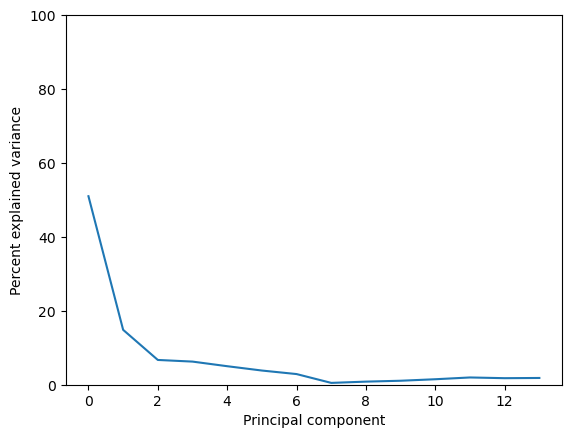

Answer: Variance explained by the first three PC: 72.56
Answer: maximum absolute projected answer 1.0393931213654508


In [139]:
def pca_on_glass_data_F2023():
    in_dir = "data/winePCA/"
    txt_name = "wine-data.txt"

    glass_data = np.loadtxt(in_dir + txt_name, comments="%")
    x = glass_data
    n_feat = x.shape[1]
    n_obs = x.shape[0]
    print(f"Number of features: {n_feat} and number of observations: {n_obs}")

    mn = np.mean(x, axis=0)
    data = x - mn

    mins = data.min(axis=0)
    maxs = data.max(axis=0)
    spread = maxs - mins
    data = data / spread

    print(f"Answer: Amount of Sodium {data[0][1]:.2f}")
    c_x = np.cov(data.T)

    print(f"Answer: Covariance matrix at (0, 0): {c_x[0][0]:.3f}")

    values, vectors = np.linalg.eig(c_x)

    v_norm = values / values.sum() * 100
    plt.plot(v_norm)
    plt.xlabel('Principal component')
    plt.ylabel('Percent explained variance')
    plt.ylim([0, 100])
    plt.show()

    answer = v_norm[0] + v_norm[1] + v_norm[2]
    print(f"Answer: Variance explained by the first three PC: {answer:.2f}")

    # Project data
    pc_proj = vectors.T.dot(data.T)

    abs_pc_proj = np.abs(pc_proj)
    max_proj_val = np.max(abs_pc_proj)
    print(f"Answer: maximum absolute projected answer {max_proj_val}")
pca_on_glass_data_F2023()

In [ ]:
def heart_pixel_analysis_e_2023():
    in_dir = "data/HeartCT/"
    im_name = "1-001.dcm"

    ct = dicom.read_file(in_dir + im_name)
    img = ct.pixel_array

    myo_roi = io.imread(in_dir + 'MyocardiumROI.png')
    myo_mask = myo_roi > 0
    myo_values = img[myo_mask]
    (mu_myo, std_myo) = norm.fit(myo_values)
    print(f"Myo: Average {mu_myo:.0f} standard deviation {std_myo:.0f}")

    blood_roi = io.imread(in_dir + 'bloodRoi.png')
    blood_mask = blood_roi > 0
    blood_values = img[blood_mask]
    (mu_blood, std_blood) = norm.fit(blood_values)
    print(f"Blood: Average {mu_blood:.0f} standard deviation {std_blood:.0f}")

    blood_gt = io.imread(in_dir + 'bloodGT.png')

    threshold = (mu_myo + mu_blood) / 2
    print(f"Answer: Threshold {threshold:.0f}")

    min_hu = mu_blood - 3 * std_blood
    max_hu = mu_blood + 3 * std_blood
    print(f"Answer: HU limits : {min_hu:0.2f} {max_hu:0.2f}")

    bin_img = (img > min_hu) & (img < max_hu)
    blood_label_colour = color.label2rgb(bin_img)
    io.imshow(blood_label_colour)
    plt.title("First blood estimate")
    io.show()

    footprint = disk(3)
    closing = binary_closing(bin_img, footprint)
    io.imshow(closing)
    plt.title("Second blood estimate")
    io.show()

    footprint = disk(5)
    opening = binary_opening(closing, footprint)
    io.imshow(opening)
    plt.title("Third blood estimate")
    io.show()

    label_img = measure.label(opening)
    n_labels = label_img.max()
    print(f"Answer: Number of labels: {n_labels}")

    region_props = measure.regionprops(label_img)

    min_area = 2000
    max_area = 5000

    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in region_props:
        a = region.area
        # p = region.perimeter

        if a < min_area or a > max_area:
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_blood = label_img_filter > 0
    io.imshow(i_blood)
    io.show()

    gt_bin = blood_gt > 0
    dice_score = 1 - distance.dice(i_blood.ravel(), gt_bin.ravel())
    print(f"Answer: DICE score {dice_score:.3f}")

In [ ]:
def cow_sheep_classifier():
    cows = [26, 46, 33, 23, 35, 28, 21, 30, 38, 43]
    sheep = [67, 27, 40, 60, 39, 45, 27, 67, 43, 50, 37, 100]

    (mu_cows, std_cows) = norm.fit(cows)
    (mu_sheep, std_sheep) = norm.fit(sheep)

    min_dist_thres = (mu_sheep + mu_cows) / 2
    print(f"Min dist threshold {min_dist_thres}")

    min_val = 20
    max_val = 110
    val_range = np.arange(min_val, max_val, 0.2)
    pdf_cows = norm.pdf(val_range, mu_cows, std_cows)
    pdf_sheep = norm.pdf(val_range, mu_sheep, std_sheep)

    test_val = 38
    cow_prob = norm.pdf(test_val, mu_cows, std_cows)
    sheep_prob = norm.pdf(test_val, mu_sheep, std_sheep)
    print(f"Cow probability {cow_prob:.2f}")
    print(f"Sheep probability {sheep_prob:.2f}")

    plt.plot(val_range, pdf_cows, 'r--', label="cows")
    plt.plot(val_range, pdf_sheep, 'g', label="sheep")
    plt.title("Fitted Gaussians")
    plt.legend()
    plt.show()

In [141]:
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Load zebra image (grayscale)
zebra_img = cv2.imread("data/zebra/Zebra.png", cv2.IMREAD_GRAYSCALE)

# Load white stripe mask
white_mask = cv2.imread("data/zebra/Zebra_whiteStripes.png", cv2.IMREAD_GRAYSCALE)

# Load black stripe mask
black_mask = cv2.imread("data/zebra/Zebra_blackStripes.png", cv2.IMREAD_GRAYSCALE)

# Flatten image and mask data
zebra_data = zebra_img.flatten()
white_mask_data = white_mask.flatten()
black_mask_data = black_mask.flatten()

# Combine data and labels (white: 1, black: 0)
data = np.vstack((zebra_data[white_mask_data == 255], zebra_data[black_mask_data == 255]))
labels = np.array([1] * np.count_nonzero(white_mask_data) + [0] * np.count_nonzero(black_mask_data))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create and train a Gaussian Naive Bayes classifier
clf = GaussianNB()
clf.fit(X_train.reshape(-1, 1), y_train)  # Reshape for single feature

# Define thresholds to evaluate
thresholds = np.linspace(0, 255, 100)

# Initialize variables for best threshold and accuracy
best_threshold = None
best_accuracy = 0

# Evaluate classifier at each threshold
for threshold in thresholds:
  predictions = (clf.predict_proba(X_test.reshape(-1, 1))[:, 1] > threshold).astype(int)
  accuracy = np.mean(predictions == y_test)
  if accuracy > best_accuracy:
    best_threshold = threshold
    best_accuracy = accuracy

print(f"Optimal threshold for classification: {best_threshold:.2f}")
print(f"Accuracy at optimal threshold: {best_accuracy:.4f}")



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 898 and the array at index 1 has size 846